In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import seaborn as sns
import numpy as np
%matplotlib inline
pd.set_option('display.max_columns',1000)

In [2]:
#set headers, otherwise the API may not return what we're looking for
HEADERS = {'user-agent': ('Mozilla/5.0(Macintosh; Intel Mac OS X 10_10_5)'
                         'AppleWebKit/537.36(KHTML, like Gecko)'
                         'Chrome/45.0.2454.101 Safari/537.36'),
          'referer': 'http://stats.nba.com/scores/'
          }

In [3]:
#get all of LeBron James' shots from 1996 to 2016 and put it into an array
playerID="2544"
seasons=[]
for season in range(2003,2016):
    #the stats.nba.com API wants season as "1996-97"
    seasonString = str(season) + '-' +str(season+1)[2:]
    
    shot_chart_url='http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS='+ seasonString +'&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID='+ playerID +'&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season='+ seasonString +'&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&TeamID=0&VsConference=&VsDivision='
    response=requests.get(shot_chart_url, headers=HEADERS)
    
    #split response into headers and content
    headers=response.json()['resultSets'][0]['headers']
    shots=response.json()['resultSets'][0]['rowSet']
    
    #create pandas datafram to hold the data
    shot_df=pd.DataFrame(shots, columns=headers)
    
    #add extra column for season
    shot_df['SEASON']=seasonString
    
    #add extra column for playoff flag
    shot_df['playoffs']=0
    
    seasons.append(shot_df)
    
#playoffs stats
for season in range(1996,2016):
    #the stats.nba.com API wants season as "1996-97"
    seasonString = str(season) + '-' +str(season+1)[2:]
    
    shot_chart_url='http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS='+ seasonString +'&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=977&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season='+ seasonString +'&SeasonSegment=&SeasonType=Playoffs&ShotClockRange=&TeamID=0&VsConference=&VsDivision='
    
    response=requests.get(shot_chart_url, headers=HEADERS)
    
    #split response into headers and content
    headers=response.json()['resultSets'][0]['headers']
    shots=response.json()['resultSets'][0]['rowSet']
    
    #create pandas datafram to hold the data
    shot_df=pd.DataFrame(shots, columns=headers)
    
    #add extra column for season
    shot_df['SEASON']=str(season)+'-'+str(season+1)[2:]
    shot_df['playoffs']=1
    
    seasons.append(shot_df)
    

In [4]:
#combine all season and playoffs dataframes into one dataframe
all_shots=pd.concat(seasons)

# dump a csv file
#all_shots.to_csv("lebron_james_all_shots.csv")

In [5]:
len(all_shots)

23957

In [6]:
all_shots.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,SEASON,playoffs
0,Shot Chart Detail,0020300014,20.0,2544.0,LeBron James,1.610613e+09,Cleveland Cavaliers,1.0,8.0,56.0,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,15.0,158.0,0.0,1.0,1.0,2003-04,0
1,Shot Chart Detail,0020300014,28.0,2544.0,LeBron James,1.610613e+09,Cleveland Cavaliers,1.0,7.0,44.0,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,13.0,-131.0,2.0,1.0,1.0,2003-04,0
2,Shot Chart Detail,0020300014,35.0,2544.0,LeBron James,1.610613e+09,Cleveland Cavaliers,1.0,7.0,1.0,Made Shot,Fadeaway Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,16.0,163.0,5.0,1.0,1.0,2003-04,0
3,Shot Chart Detail,0020300014,39.0,2544.0,LeBron James,1.610613e+09,Cleveland Cavaliers,1.0,6.0,29.0,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,14.0,-118.0,92.0,1.0,0.0,2003-04,0
4,Shot Chart Detail,0020300014,54.0,2544.0,LeBron James,1.610613e+09,Cleveland Cavaliers,1.0,4.0,48.0,Made Shot,Running Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,5.0,54.0,22.0,1.0,1.0,2003-04,0


In [7]:
#combine shot types
all_shots['COMBINED_SHOT_TYPE']=all_shots['ACTION_TYPE']

all_shots.replace(to_replace={
        'COMBINED_SHOT_TYPE':{
            '(.+)?Jump (.+)?(S|s)hot':'Jump Shot',
            '(.+)?Fadeaway(.+)?':'Jump Shot',
            '(.+)?Dunk Shot':'Dunk',
            '(.+)?Layup (S|s)hot':"Layup",
            '(.+)?Hook.+':"Hook Shot",
            '(.+)?Tip.+':"Tip Shot",
            '(.+)?Bank.+':"Bank Shot",
            '(.+)?Finger Roll.+':"Layup"
        }
    }, regex=True, inplace=True)
all_shots.COMBINED_SHOT_TYPE.value_counts()

Jump Shot    15333
Layup         6077
Dunk          1690
Bank Shot      444
Hook Shot      219
Tip Shot       194
Name: COMBINED_SHOT_TYPE, dtype: int64

In [8]:
#draw the court
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    #if an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()
    
    #create the various parts of an NBA basketball court
    
    #create the basketball hoop
    #diameter of a hoop is 18" so it has a radius of 9", which is a value of 7.5 in our coordinate system
    hoop = Circle((0,0), radius = 7.5, linewidth=lw, color=color, fill=False)

    #create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    
    #the paint
    #create the outer box of the paint, width=16 ft, height=19 ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    
    #create the inner box of the paint, width=12 ft, hieght=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)
   
    #create the free throw top arc
    top_free_throw=Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    
    #create the free throw bottom arc
    bottom_free_throw=Arc((0, 142.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color, linestyle='dashed')
    
    #restricted zone, arc with 4 ft radius from center of the hoop
    restricted=Arc((0,0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)

    #three point line
    #create the side 3 point lines, 14 ft long before they before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    
    corner_three_b = Rectangle((220, -47.5), 0, 140,  linewidth=lw, color=color)
    
    #three point arc, center of the arc will be the hoop, arc is 23 ft 9 inches away from the hoop
    three_arc = Arc((0,0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)
    
    #center court
    center_outer_arc = Arc((0,422.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color)
    
    center_inner_arc = Arc((0,422.5), 40, 40, theta1=180, theta2=0, linewidth=lw, color=color)
    
    #list of court elements to be poltted onto the axes
    court_elements=[hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw,
                   restricted, corner_three_a, corner_three_b, three_arc, center_outer_arc, center_inner_arc]
    
    if outer_lines:
        #draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)
        court_elements.append(outer_lines)
        
    #add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)
        
    return ax


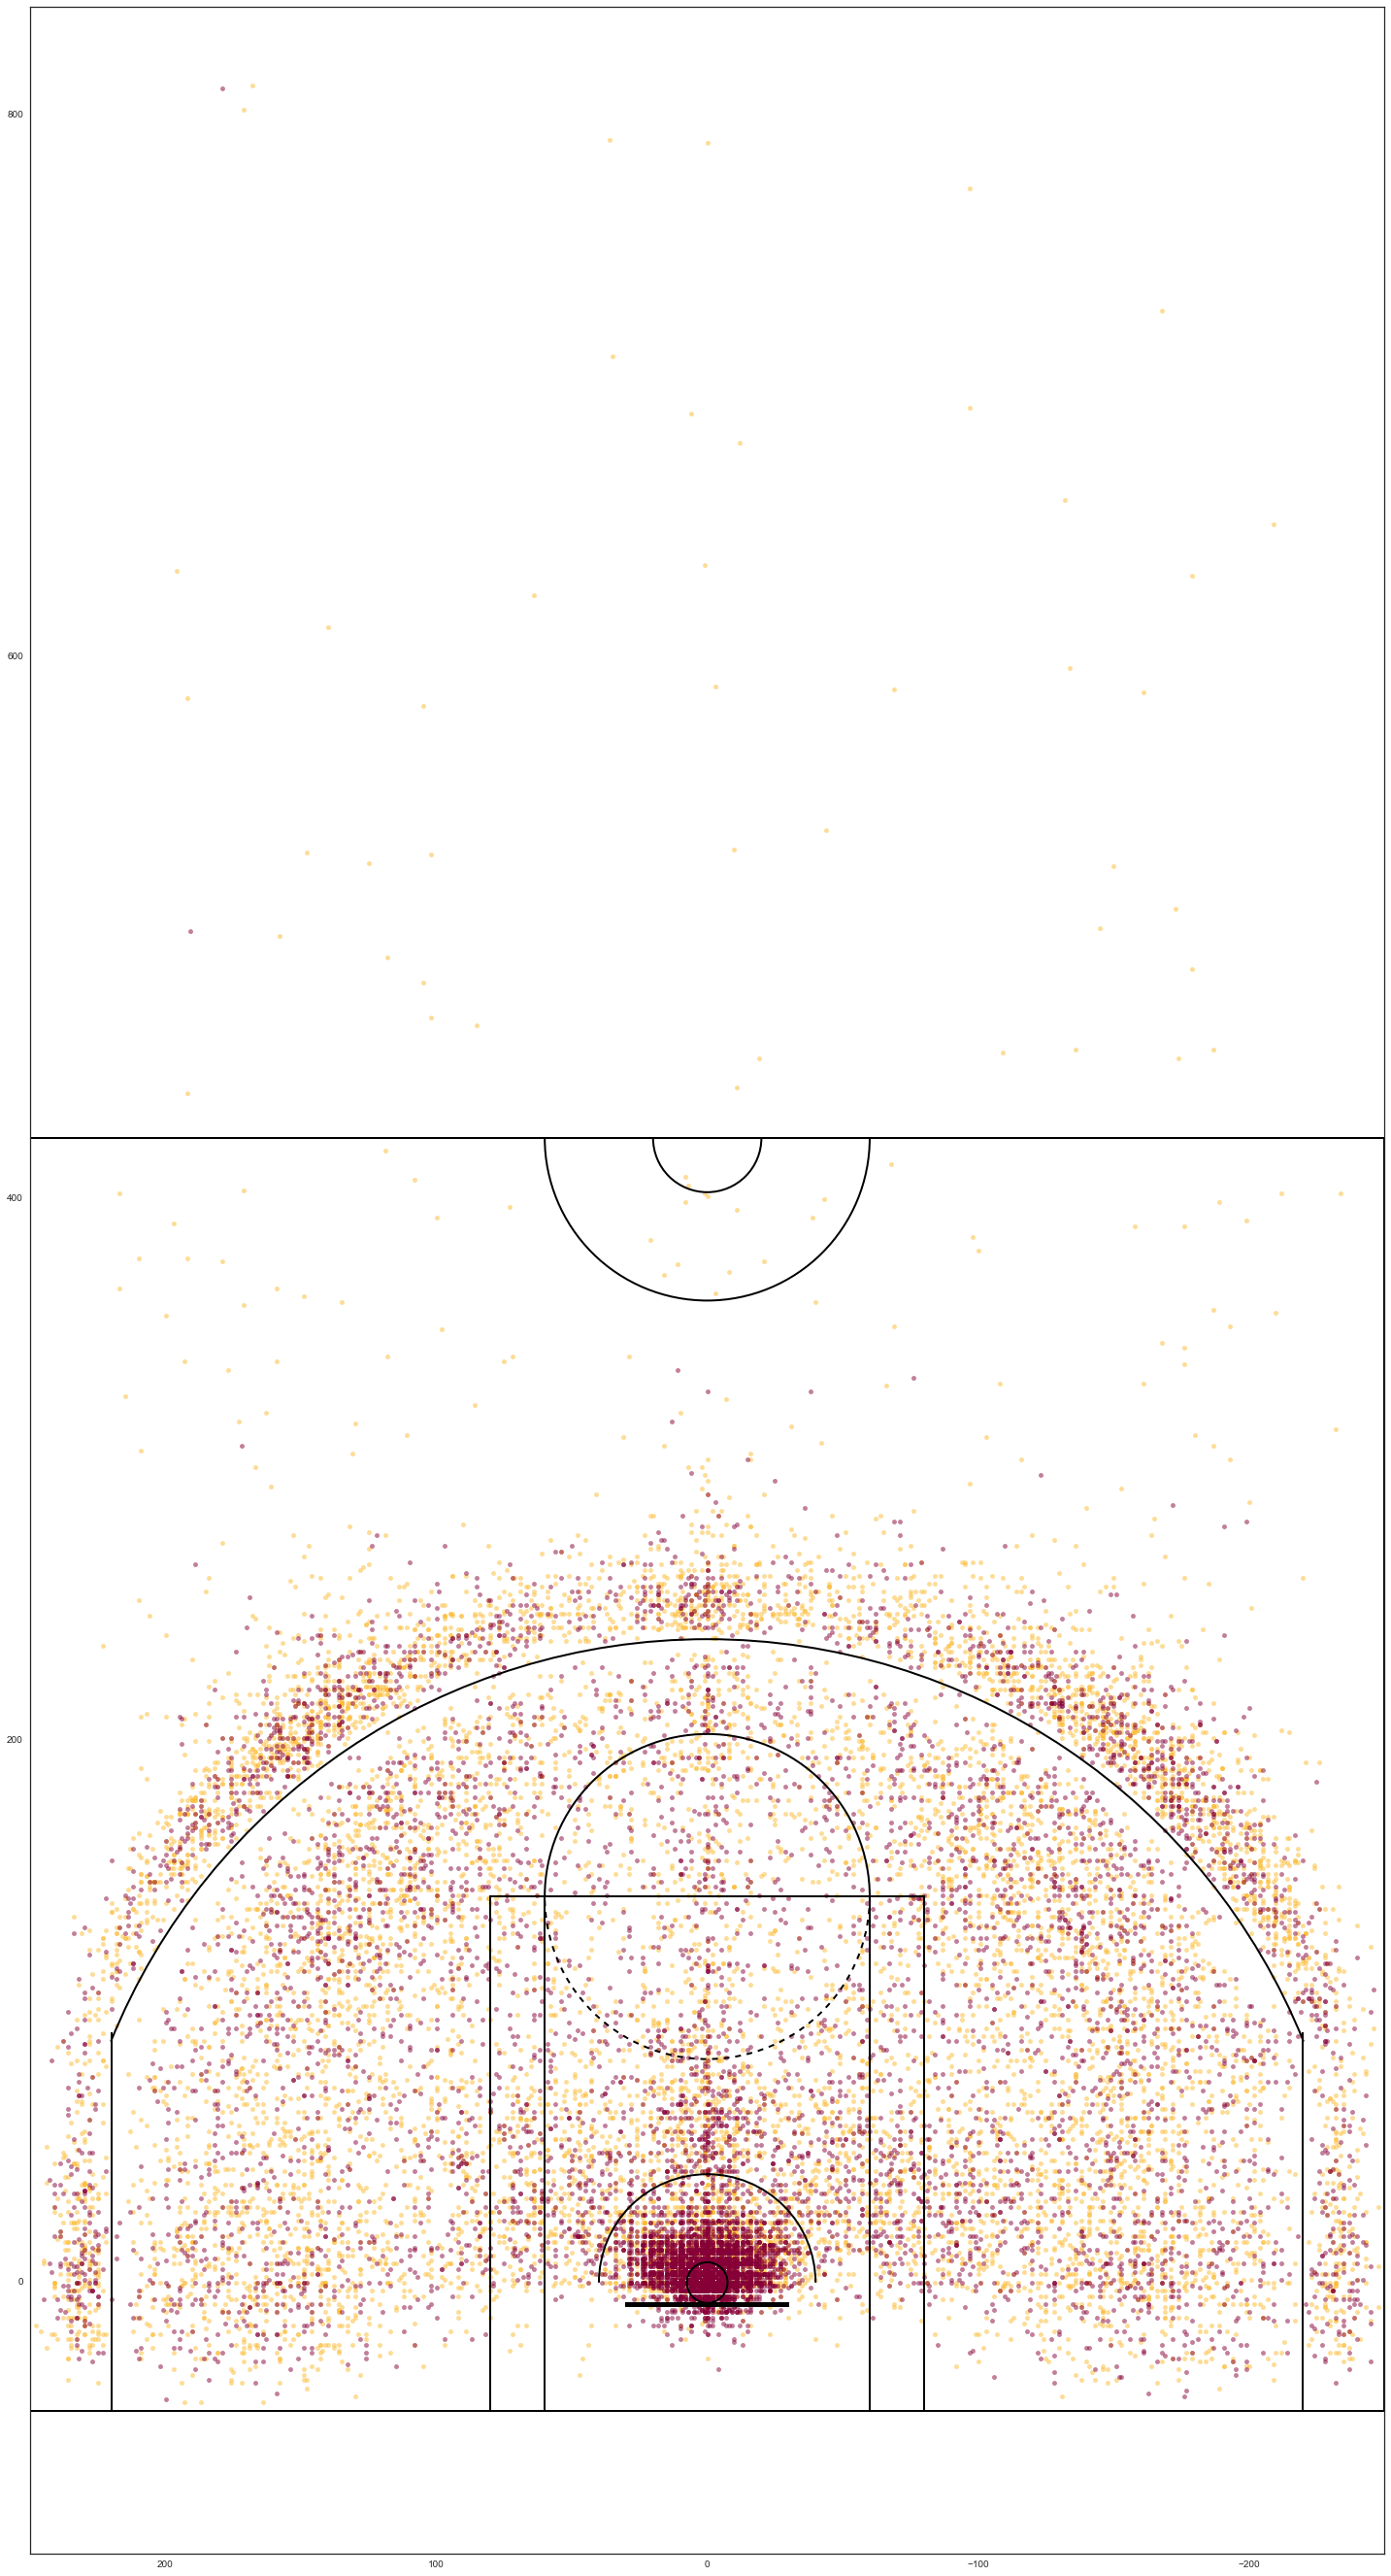

In [9]:
#plot all the shots
sns.set_style("white")
sns.set_color_codes()
all_shot_fig=plt.figure(figsize=(25,47),dpi=72)
all_shot_ax=all_shot_fig.add_subplot(111)

all_shot_ax.set_ylim([-100,840])
all_shot_ax.set_xlim([250,-250])

draw_court(ax=all_shot_ax,outer_lines=True)

#first, draw the missed shots
all_shot_ax.scatter(all_shots[(all_shots.EVENT_TYPE=="Missed Shot")].LOC_X,all_shots[(all_shots.EVENT_TYPE=="Missed Shot")].LOC_Y, color='#FDBB30', alpha=0.5)

#then made shots
all_shot_ax.scatter(all_shots[(all_shots.EVENT_TYPE=="Made Shot")].LOC_X,all_shots[(all_shots.EVENT_TYPE=="Made Shot")].LOC_Y, color='#860038', alpha=0.5)
                    